In [3]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta #datetime is a module which contains date and timedelta classes.timedelta-represents diff. b/w two dates or time

# Set dates
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=40)).strftime("%Y-%m-%d")

# Define tickers
tickers = ['AAPL', 'MSFT', 'NFLX', 'GOOG', 'TSLA']

# Download data
data = yf.download(tickers, start=start_date, end=end_date, progress=False)


# Reset index to turn the date index into a column
data = data.reset_index() #it is used to reset the index of data starting from 0 and makes it easier to work with the dataframes


 # Flatten the MultiIndex columns 
#It's purpose is to ensure that all columns name in the dataframe data are formatted and flattened for easier handling and analysis
data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in data.columns.values]

# Display the new column names
#print(data.columns)

# Melt the data(melt() function is used to reshape a DataFrame from a wide format to a long format. This is also known as "unpivoting" the data.)
data_melted = data.melt(id_vars=['Date'], var_name='Attribute_Ticker', value_name='value')

# Split 'Attribute_Ticker' into 'Attribute' and 'Ticker' Columns
data_melted[['Attribute', 'Ticker']] = data_melted['Attribute_Ticker'].str.split('_', expand=True)

# Drop the unnecessary 'Attribute_Ticker' column
data_melted = data_melted.drop(columns=['Attribute_Ticker'])

# Pivot(a neat process that transforms a DataFrame into a new one by converting selected columns into new columns based on their values) the data
# pivot_table function is a powerful tool for data analysis. It allows you to summarize and reshape data in a DataFrame
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# Reset index for the final DataFrame
stock_data = data_pivoted.reset_index()

#common practice in data analysis to confirm that data manipulations have been performed coorectly and to give overview of dataframe
print(stock_data.head())

Attribute       Date Ticker   Adj Close       Close        High         Low  \
0         2024-06-10   AAPL  193.119995  193.119995  197.300003  192.149994   
1         2024-06-10   GOOG  176.630005  176.630005  178.470001  174.380005   
2         2024-06-10   MSFT  427.869995  427.869995  428.079987  423.890015   
3         2024-06-10   NFLX  644.500000  644.500000  644.789978  635.590027   
4         2024-06-10   TSLA  173.789993  173.789993  178.570007  173.169998   

Attribute        Open      Volume  
0          196.899994  97262100.0  
1          176.449997  17122200.0  
2          424.700012  14003000.0  
3          641.010010   2066800.0  
4          176.059998  50869700.0  


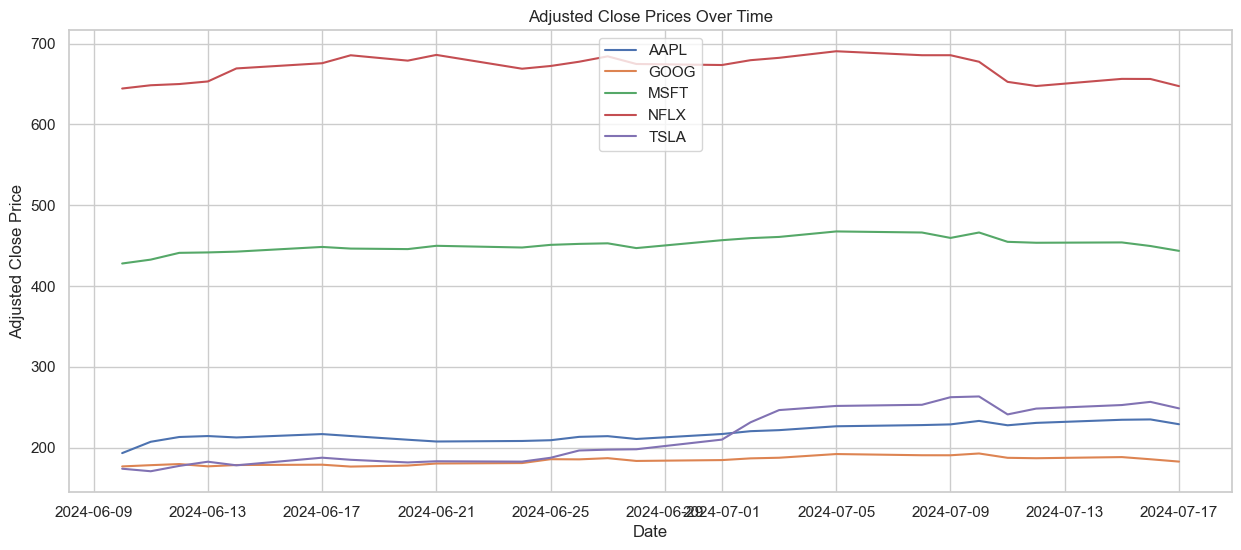

In [7]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Setting seaborn style to whitegrid (optional)
sns.set(style="whitegrid")

# Assuming 'stock_data' is your DataFrame containing stock data, with columns like 'Ticker', 'Date', and 'Adj Close'

# Plotting adjusted close prices for each ticker over time
plt.figure(figsize=(15, 6))  # Setting figure size

# Iterating over each unique ticker in the DataFrame
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]  # Subset of data for current ticker
    plt.plot(subset['Date'], subset['Adj Close'], label=ticker)  # Plotting Adj Close against date for current ticker

# Adding labels and title
plt.title('Adjusted Close Prices Over Time')  # Setting title
plt.xlabel('Date')  # Setting x-axis label
plt.ylabel('Adjusted Close Price')  # Setting y-axis label

plt.legend()  # Adding legend based on 'Ticker' values
plt.show()  # Displaying the plot


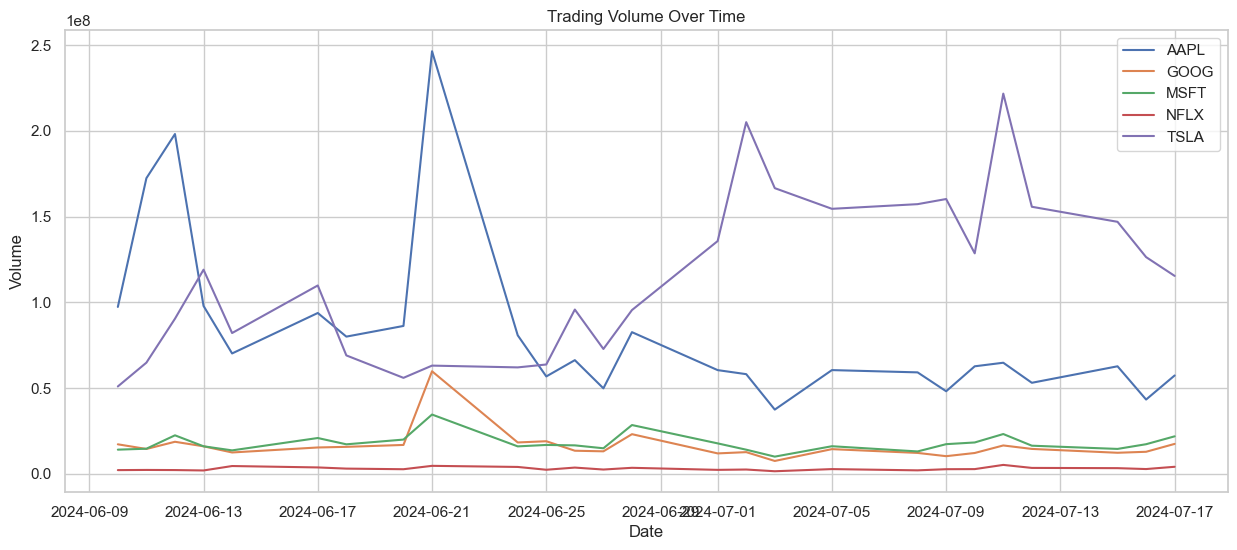

In [6]:

# Assuming 'stock_data' is your DataFrame containing stock data, with columns like 'Ticker', 'Date', and 'Volume'

# Plotting trading volume for each ticker over time
plt.figure(figsize=(15, 6))  # Setting figure size

# Iterating over each unique ticker in the DataFrame
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]  # Subset of data for current ticker
    plt.plot(subset['Date'], subset['Volume'], label=ticker)  # Plotting Volume against date for current ticker

# Adding labels and title
plt.title('Trading Volume Over Time')  # Setting title
plt.xlabel('Date')  # Setting x-axis label
plt.ylabel('Volume')  # Setting y-axis label

plt.legend()  # Adding legend based on 'Ticker' values
plt.show()  # Displaying the plot


In [12]:
# Import necessary libraries
from scipy.stats import zscore

# Function to detect anomalies using Z-score
def detect_anomalies(df, column):
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    df_copy['Z-score'] = zscore(df_copy[column])  # Calculate Z-scores for the specified column
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]  # Identify anomalies where absolute Z-score is greater than 2
    return anomalies  # Return DataFrame containing anomalies
    
# Initialize empty DataFrames to store anomalies for adjusted close and volume
anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

# Iterate over each unique ticker in the 'Ticker' column of stock_data DataFrame
for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]  # Subset of data for current ticker
    
    # Detect anomalies in 'Adj Close' for current ticker and concatenate to anomalies_adj_close DataFrame
    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    
    # Detect anomalies in 'Volume' for current ticker and concatenate to anomalies_volume DataFrame
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])
    
# Print the first few rows of anomalies_adj_close DataFrame to inspect detected anomalies
print(anomalies_adj_close.head())


Attribute       Date Ticker   Adj Close       Close        High         Low  \
5         2024-06-10   AAPL  193.119995  193.119995  197.300003  192.149994   
2         2024-06-07   MSFT  423.850006  423.850006  426.279999  423.000000   
7         2024-06-10   MSFT  427.869995  427.869995  428.079987  423.890015   

Attribute        Open      Volume   Z-score  
5          196.899994  97262100.0 -2.217886  
2          426.200012  13621700.0 -2.442187  
7          424.700012  14003000.0 -2.065913  


In [6]:
# Print the first few rows of anomalies_volume DataFrame to inspect detected anomalies
print(anomalies_volume.head())

Attribute       Date Ticker   Adj Close       Close        High         Low  \
15        2024-06-12   AAPL  213.070007  213.070007  220.199997  206.899994   
45        2024-06-21   AAPL  207.490005  207.490005  211.889999  207.110001   
46        2024-06-21   GOOG  180.259995  180.259995  182.511993  178.059998   
47        2024-06-21   MSFT  449.779999  449.779999  450.579987  446.510010   
72        2024-06-28   MSFT  446.950012  446.950012  455.380005  446.410004   

Attribute        Open       Volume   Z-score  
15         207.369995  198134300.0  2.394578  
45         210.389999  246421400.0  3.393069  
46         178.490005   59728000.0  4.708472  
47         447.380005   34486200.0  3.399230  
72         453.070007   28362300.0  2.171951  


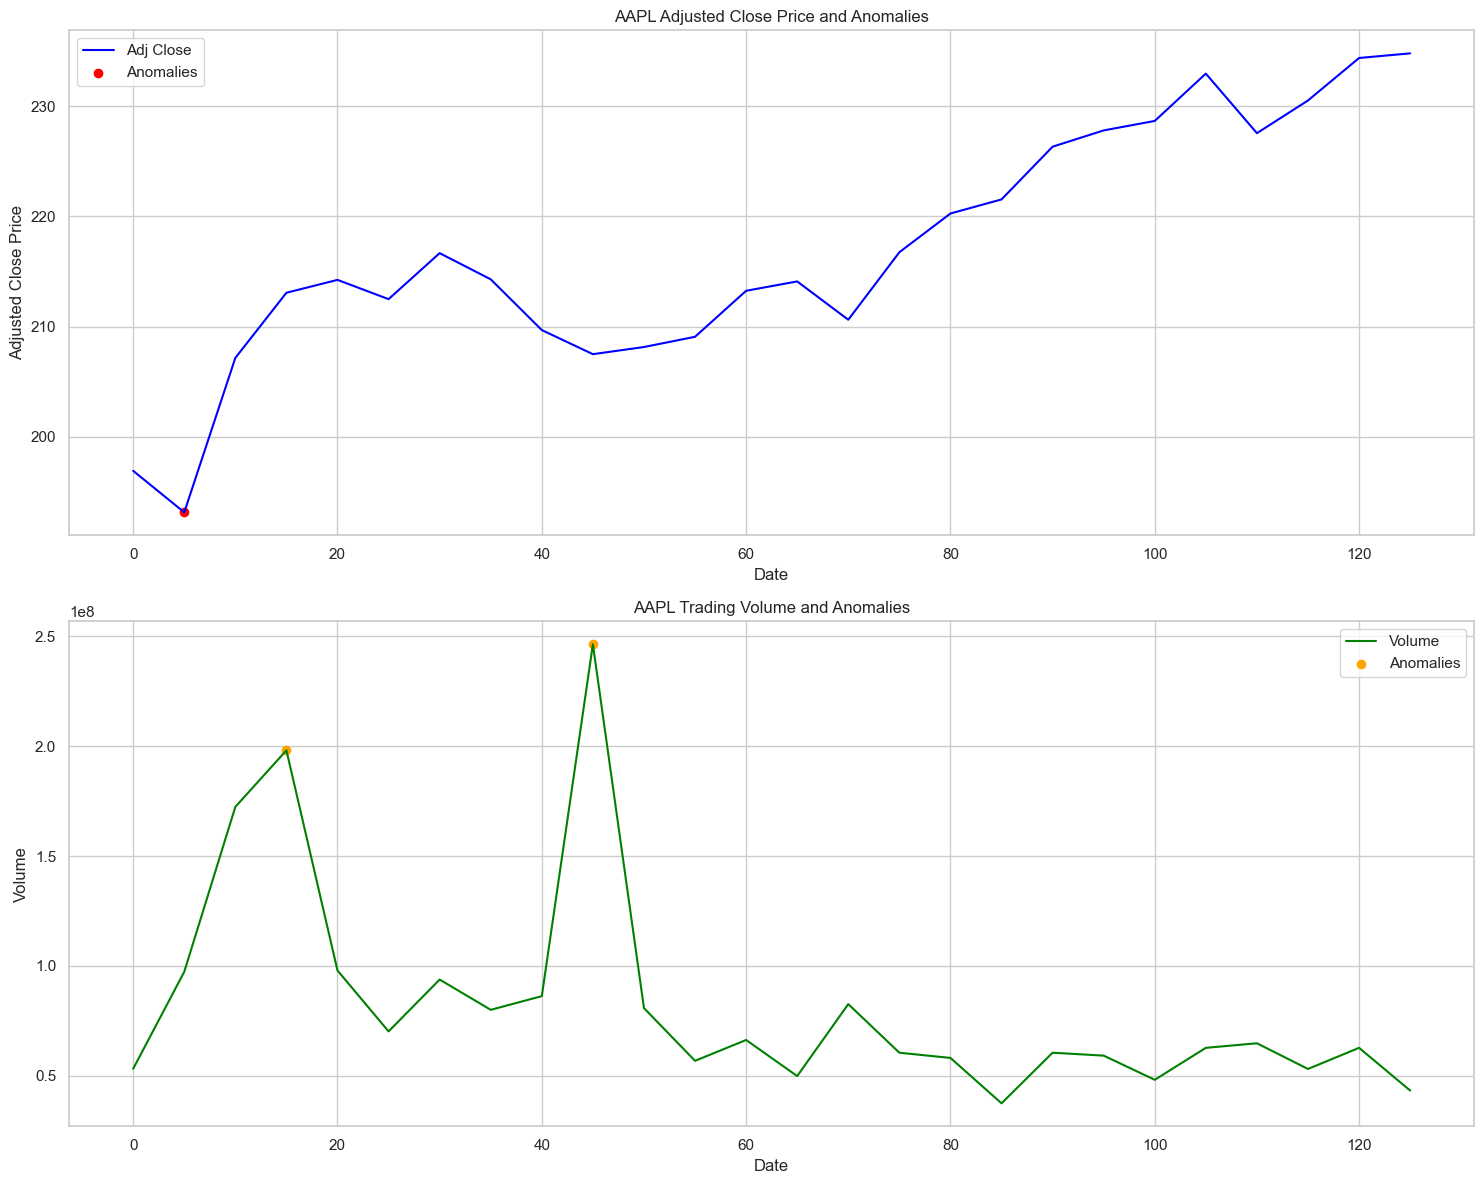

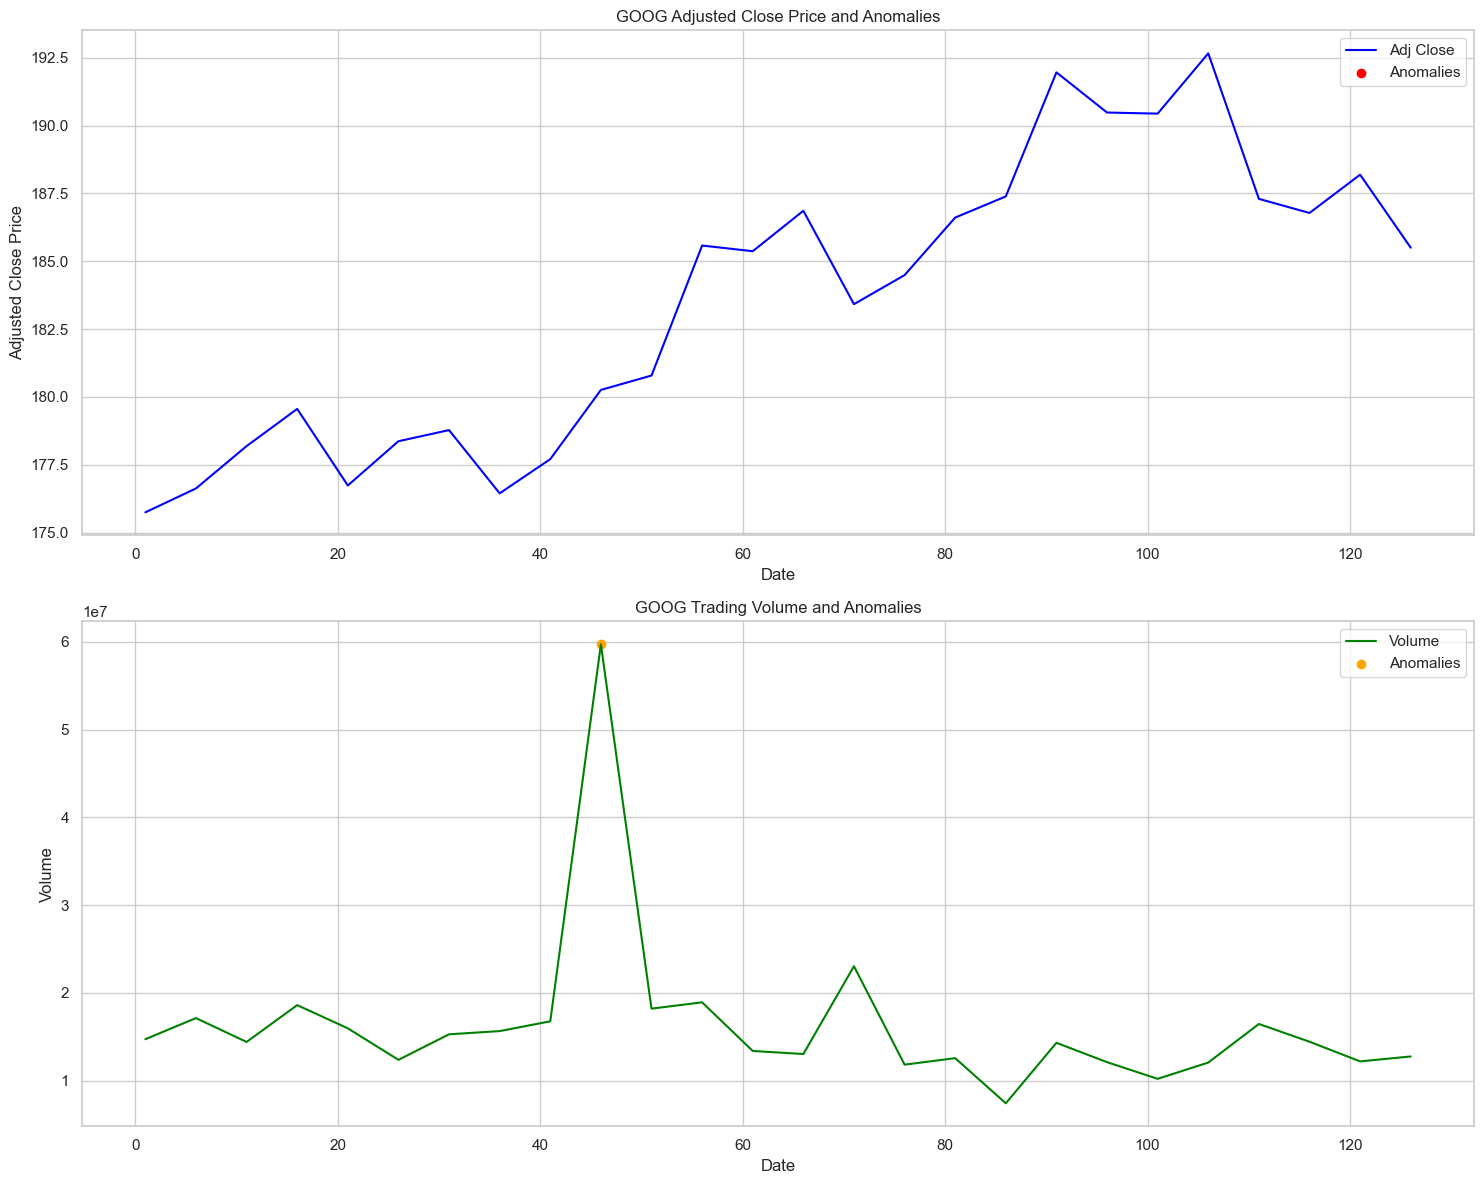

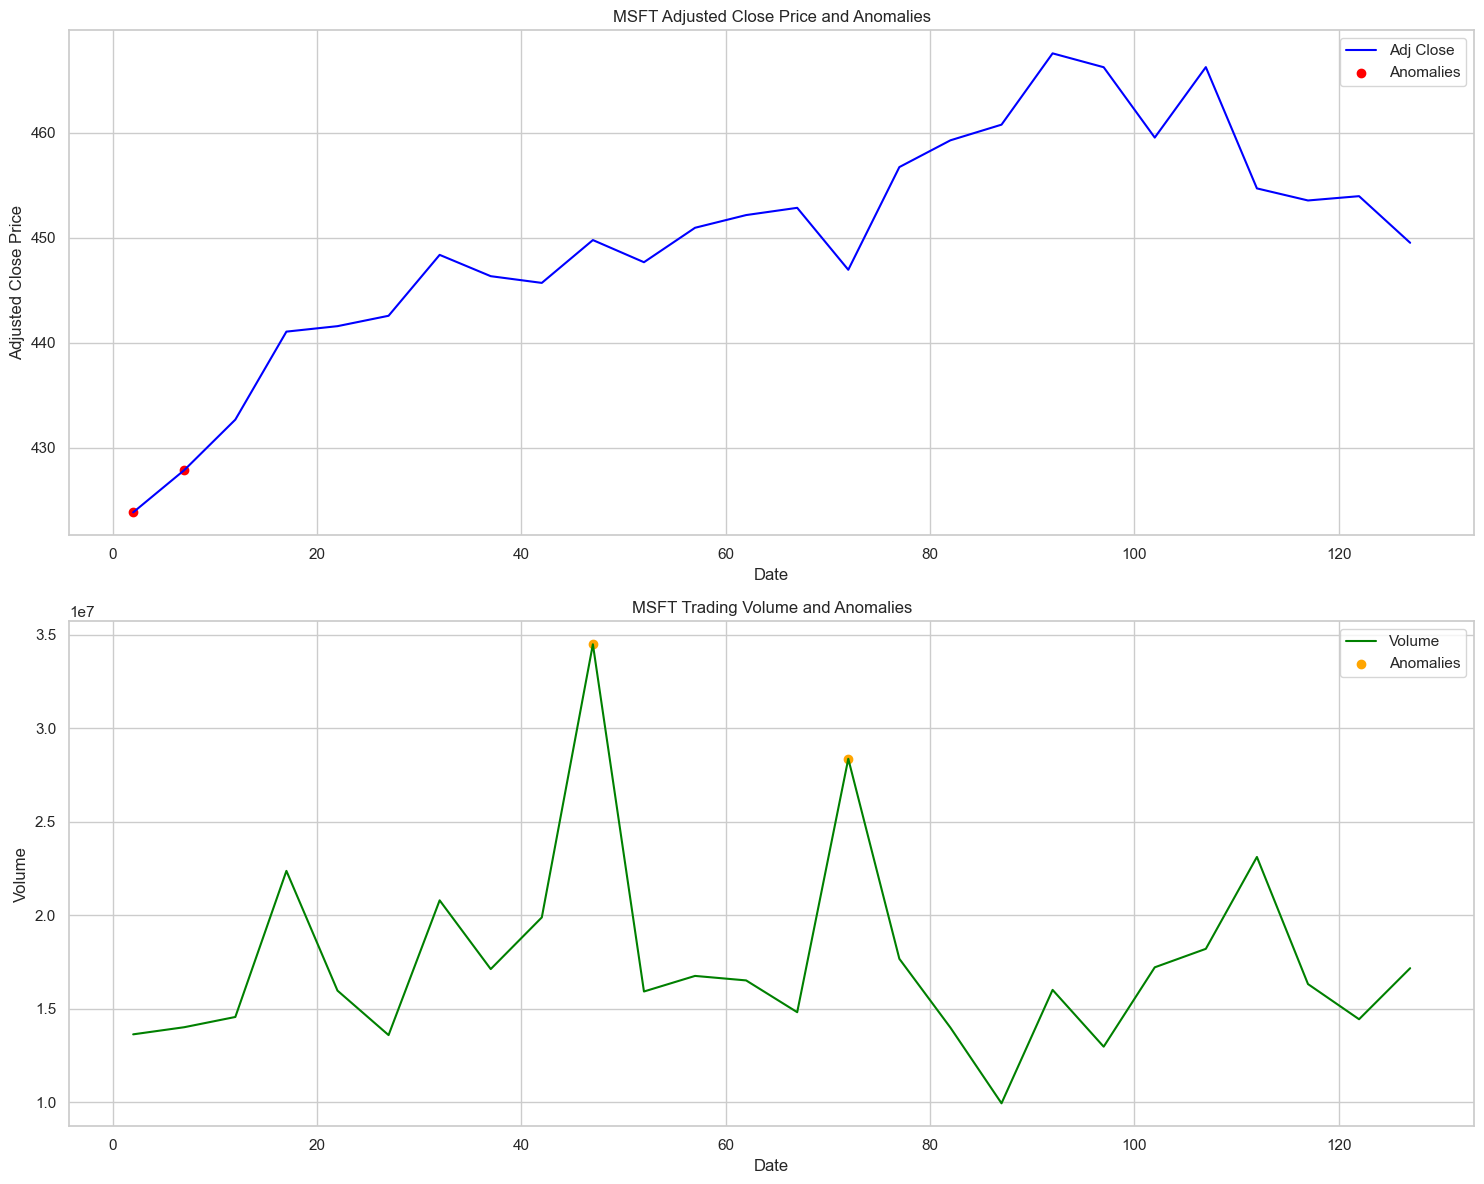

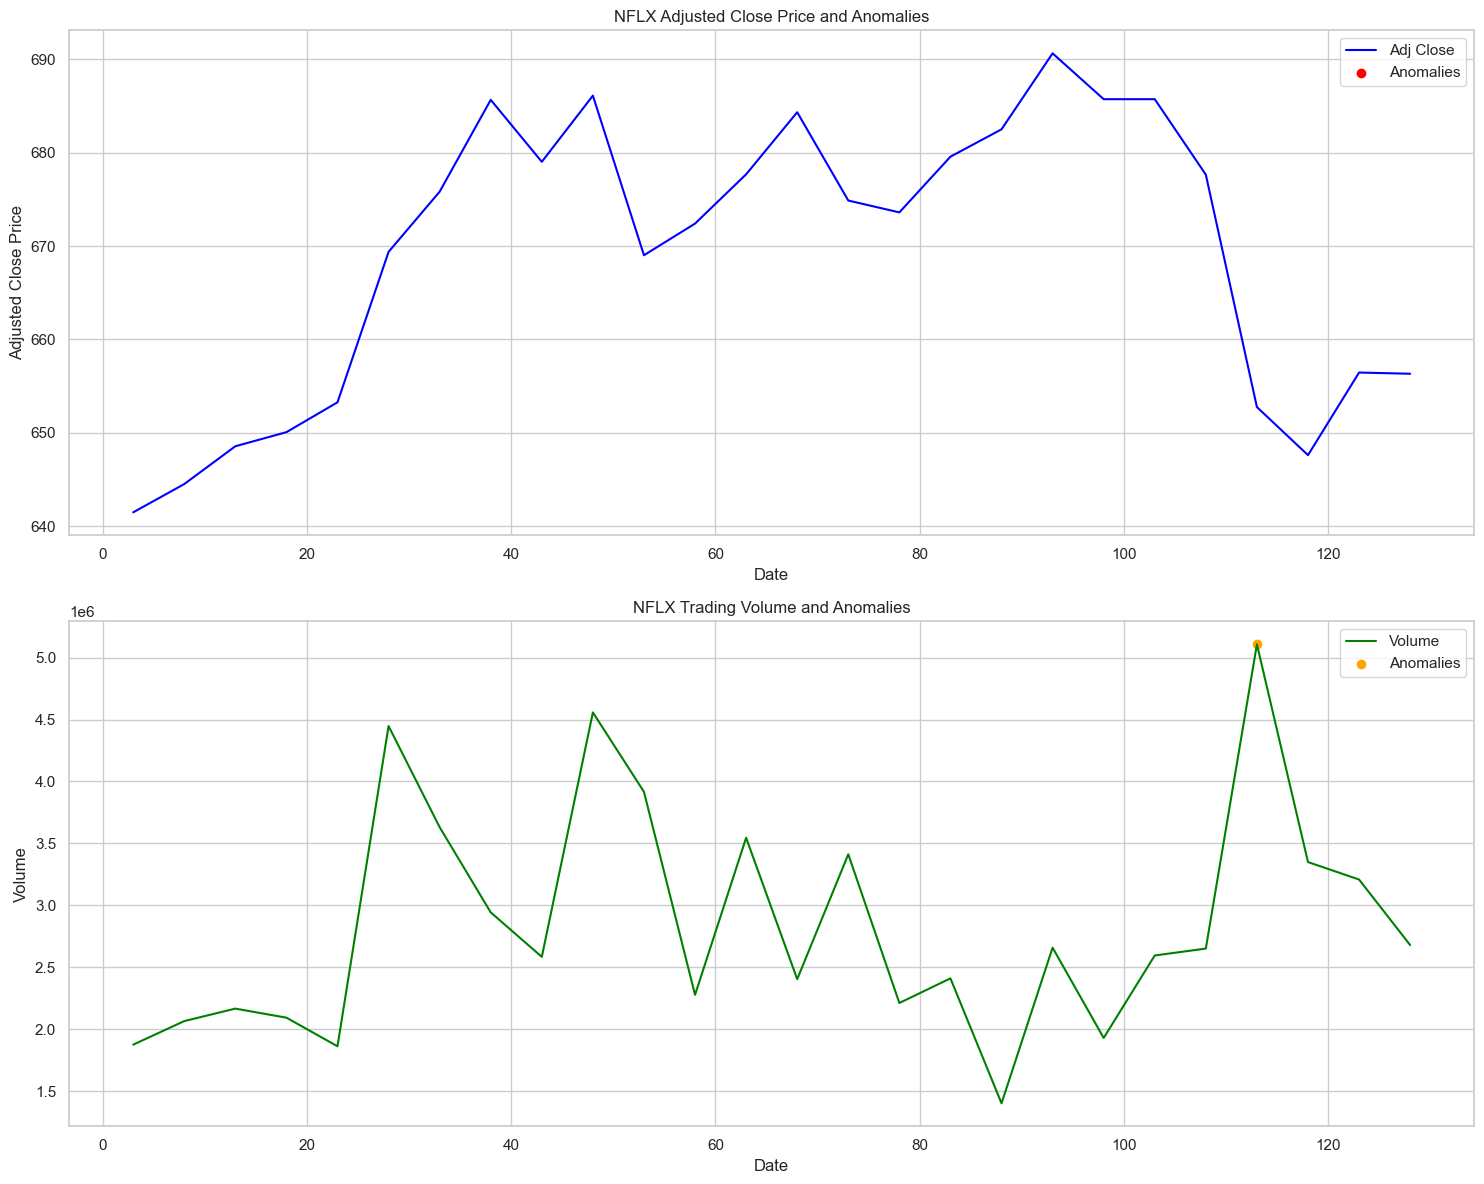

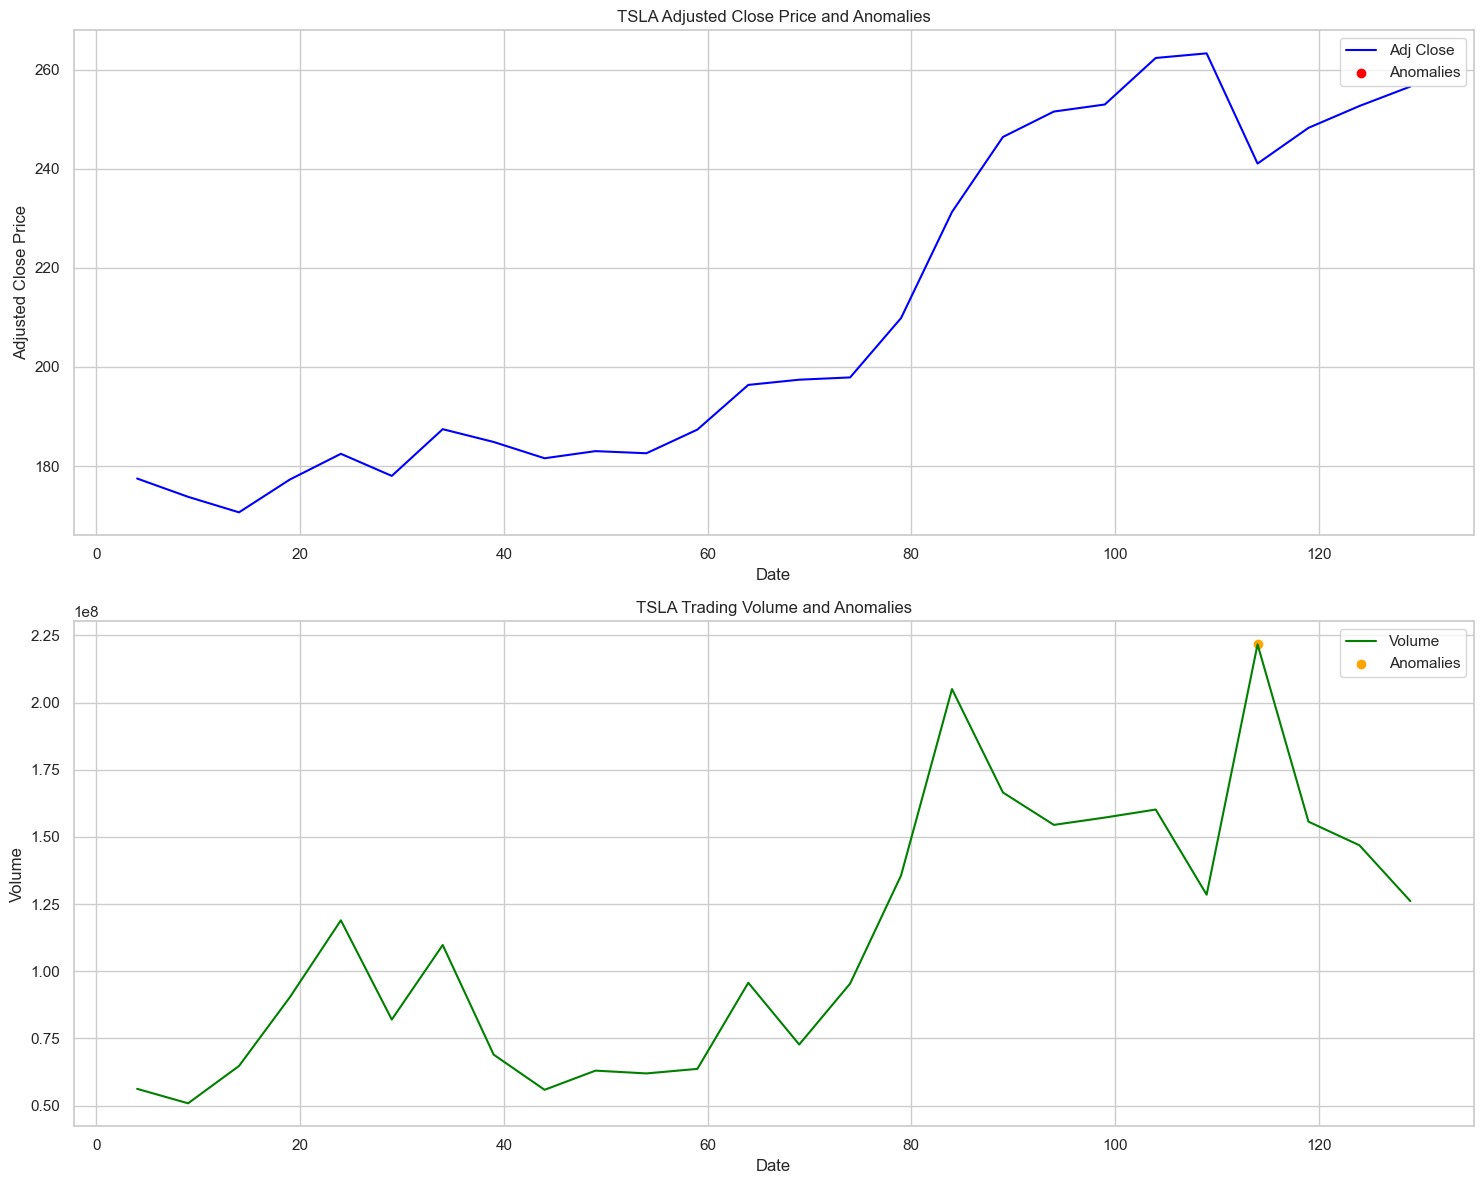

In [7]:

# Assume stock_data, anomalies_adj_close, and anomalies_volume are already defined DataFrames

# Function to plot anomalies for a given ticker
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]
    
    # Plotting setup
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))  # Create subplots with 2 rows and 1 column
    
    # Adjusted close price plot
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')  # Main plot
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')  # Anomalies as scatter points
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')  # Title
    ax1.set_xlabel('Date')  # X-axis label
    ax1.set_ylabel('Adjusted Close Price')  # Y-axis label
    ax1.legend()  # Legend
    
    # Volume plot
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')  # Main plot
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')  # Anomalies as scatter points
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')  # Title
    ax2.set_xlabel('Date')  # X-axis label
    ax2.set_ylabel('Volume')  # Y-axis label
    ax2.legend()  # Legend
    
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()  # Display the plot

# Iterate over each unique ticker in stock_data and plot anomalies
for ticker in stock_data['Ticker'].unique():
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)


In [8]:

# Assume anomalies_adj_close and anomalies_volume are already defined DataFrames with 'Ticker' and 'Date' columns

# Consolidate anomalies for adjusted close prices
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # Indicator variable for anomalies

# Consolidate anomalies for volumes
all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1  # Indicator variable for anomalies

# Pivot these dataframes to have one row per date and columns for each ticker, filling non-anomalies with 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index,
                                                     columns='Ticker', fill_value=0, aggfunc='sum')
volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index,
                                               columns='Ticker', fill_value=0, aggfunc='sum')

# Flatten the multi-level column index
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

# Combine the two pivoted dataframes
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1,
                               keys=['Adj Close Anomaly', 'Volume Anomaly'])

# Calculate the correlation matrix for the anomalies
correlation_matrix = combined_anomalies.corr()

# Print the correlation matrix
print(correlation_matrix)


                         Adj Close Anomaly      Volume Anomaly            \
Ticker                                AAPL MSFT           AAPL      GOOG   
                  Ticker                                                   
Adj Close Anomaly AAPL                 1.0 -1.0            NaN       NaN   
                  MSFT                -1.0  1.0            NaN       NaN   
Volume Anomaly    AAPL                 NaN  NaN       1.000000 -0.258199   
                  GOOG                 NaN  NaN      -0.258199  1.000000   
                  MSFT                 NaN  NaN      -0.400000 -0.258199   
                  NFLX                 NaN  NaN      -0.258199 -0.166667   
                  TSLA                 NaN  NaN      -0.258199 -0.166667   

                                                        
Ticker                        MSFT      NFLX      TSLA  
                  Ticker                                
Adj Close Anomaly AAPL         NaN       NaN       NaN  
           

In [9]:

# Assume anomalies_adj_close and anomalies_volume are already defined DataFrames with 'Ticker' and 'Z-score' columns

# Calculate the mean absolute Z-score for adjusted close price anomalies for each ticker
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# Calculate the mean absolute Z-score for volume anomalies for each ticker
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# Combine the risk scores from both adjusted close price and volume anomalies
total_risk = adj_close_risk + volume_risk

# Normalize the risk scores to get a relative risk rating from 0 to 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

# Print the relative risk rating for each ticker
print(risk_rating)


Ticker
AAPL    1.0
GOOG    NaN
MSFT    0.0
NFLX    NaN
TSLA    NaN
Name: Z-score, dtype: float64


In [ ]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from twilio.rest import Client  # Make sure you have installed twilio package

# Function to send email
def send_email(smtp_server, smtp_port, smtp_username, smtp_password, subject, body, to_email):
    msg = MIMEMultipart()
    msg['From'] = smtp_username
    msg['To'] = to_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))
    
    # Connect to SMTP server
    server = smtplib.SMTP(smtp_server, smtp_port)
    server.starttls()  # Start TLS encryption
    server.login(smtp_username, smtp_password)  # Login to email server
    text = msg.as_string()
    server.sendmail(smtp_username, to_email, text)  # Send email
    server.quit()  # Quit SMTP server

# Function to send SMS
def send_sms(twilio_account_sid, twilio_auth_token, twilio_phone_number, body, to_number):
    client = Client(twilio_account_sid, twilio_auth_token)
    message = client.messages.create(body=body, from_=twilio_phone_number, to=to_number)
    print(f'SMS sent to {to_number}: {message.sid}')  # Confirmation message

if __name__ == '__main__':
    # Input email and SMS details
    email_address = input("Enter your email address: ")
    sms_number = input("Enter your mobile number (with country code): ")
    
    # Email settings
    smtp_server = 'smtp.gmail.com'
    smtp_port = 587
    smtp_username = 'abc@gmail.com'  # Update with your email address
    smtp_password =   # Update with your email password
    
    # Twilio settings
    twilio_account_sid = # Update with your Twilio Account SID
    twilio_auth_token =  # Update with your Twilio Auth Token
    twilio_phone_number =  # Update with your Twilio phone number
    
    # Example notification when anomalies are detected
    if not anomalies_adj_close.empty or not anomalies_volume.empty:
        subject = 'Stock Anomalies Detected'
        body = 'Anomalies have been detected in the stock data. Please check the analysis results.\n'
        body += f'Risk ratings:\n{risk_rating}'  # Include risk ratings in the email body
        
        # Send email notification
        send_email(smtp_server, smtp_port, smtp_username, smtp_password, subject, body, email_address)
        
        # Send SMS notification
        send_sms(twilio_account_sid, twilio_auth_token, twilio_phone_number, body, sms_number)
        
        print('Notifications sent.')  # Confirmation message
